In [1]:
import math
import io
import torch
from torchvision import transforms
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
from pytorch_msssim import ms_ssim
#from compressai.zoo import bmshj2018_factorized
from compressai.zoo import (bmshj2018_factorized, bmshj2018_hyperprior, mbt2018_mean, mbt2018, cheng2020_anchor)
from ipywidgets import interact, widgets

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
net = bmshj2018_factorized(quality=2, pretrained=True).eval().to(device)
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


In [5]:
img = Image.open('/trinity/home/a.jha/scripts/Image_Compression/Kodim20/kodim_new8.png').convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)

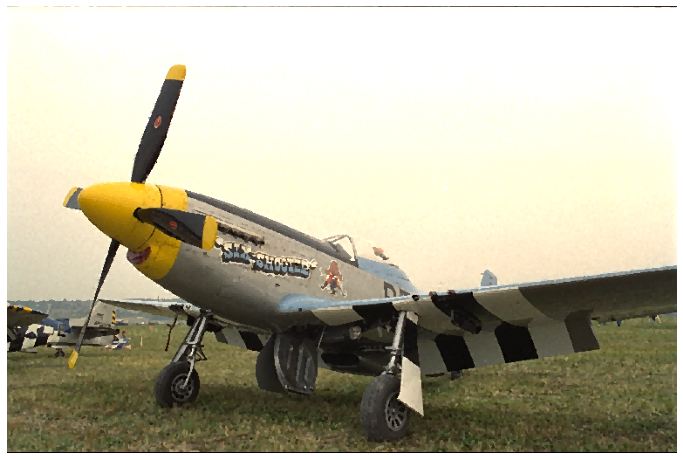

In [6]:
%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()

In [7]:
with torch.no_grad():
    out_net = net.forward(x)
out_net['x_hat'].clamp_(0, 1)
print(out_net.keys())

dict_keys(['x_hat', 'likelihoods'])


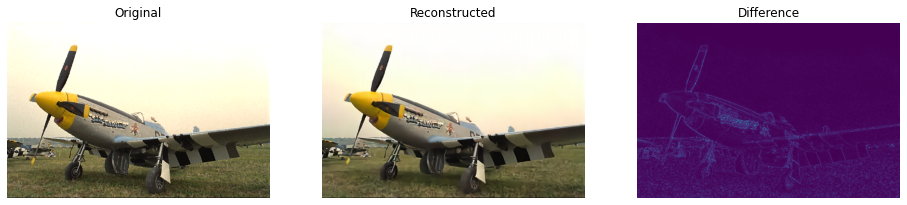

In [8]:
rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
diff = torch.mean((out_net['x_hat'] - x).abs(), axis=1).squeeze().cpu()
%matplotlib inline
fix, axes = plt.subplots(1, 3, figsize=(16, 12))
for ax in axes:
    ax.axis('off')
    
axes[0].imshow(img)
axes[0].title.set_text('Original')

axes[1].imshow(rec_net)
axes[1].title.set_text('Reconstructed')

axes[2].imshow(diff, cmap='viridis')
axes[2].title.set_text('Difference')

plt.show()

In [9]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()
print(f'PSNR: {compute_psnr(x, out_net["x_hat"]):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, out_net["x_hat"]):.4f}')
print(f'Bit-rate: {compute_bpp(out_net):.3f} bpp')

PSNR: 29.39dB
MS-SSIM: 0.9611
Bit-rate: 0.157 bpp


In [92]:
def pillow_encode(img, fmt='jpeg', quality=10):
    tmp = io.BytesIO()
    img.save(tmp, format=fmt, quality=quality)
    tmp.seek(0)
    filesize = tmp.getbuffer().nbytes
    bpp = filesize * float(8) / (img.size[0] * img.size[1])
    rec = Image.open(tmp)
    return rec, bpp

In [93]:
from functools import partial

In [94]:
def find_closest_bpp(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        if bpp > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp

def find_closest_psnr(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    
    def _psnr(a, b):
        a = np.asarray(a).astype(np.float32)
        b = np.asarray(b).astype(np.float32)
        mse = np.mean(np.square(a - b))
        return 20*math.log10(255.) -10. * math.log10(mse)
    
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        prev_mid = mid
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        psnr_val = _psnr(rec, img)
        if psnr_val > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp, psnr_val

def find_closest_msssim(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    
    def _mssim(a, b):
        a = torch.from_numpy(np.asarray(a).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
        b = torch.from_numpy(np.asarray(b).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
        return ms_ssim(a, b, data_range=255.).item()

    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        prev_mid = mid
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        msssim_val = _mssim(rec, img)
        if msssim_val > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp, msssim_val

In [95]:
target_bpp = compute_bpp(out_net)
rec_jpeg, bpp_jpeg = find_closest_bpp(target_bpp, img)
rec_webp, bpp_webp = find_closest_bpp(target_bpp, img, fmt='webp')

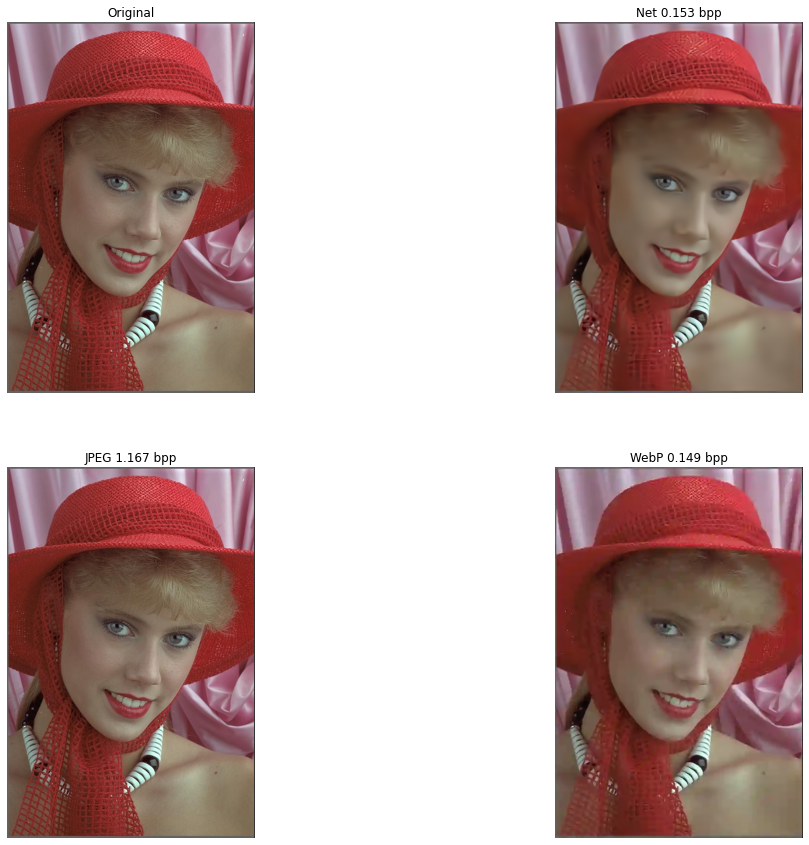

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for ax in axes.ravel():
    ax.axis('off')

fig.title = 'yolo'
axes[0][0].imshow(img)
axes[0][0].title.set_text('Original')
axes[0][1].imshow(rec_net)
axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp')
axes[1][0].imshow(rec_jpeg)
axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp')
axes[1][1].imshow(rec_webp)
axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp')

plt.show()

In [97]:
target_psnr = compute_psnr(x, out_net["x_hat"])
rec_jpeg, bpp_jpeg, psnr_jpeg = find_closest_psnr(target_psnr, img)
rec_webp, bpp_webp, psnr_webp = find_closest_psnr(target_psnr, img, fmt='webp')

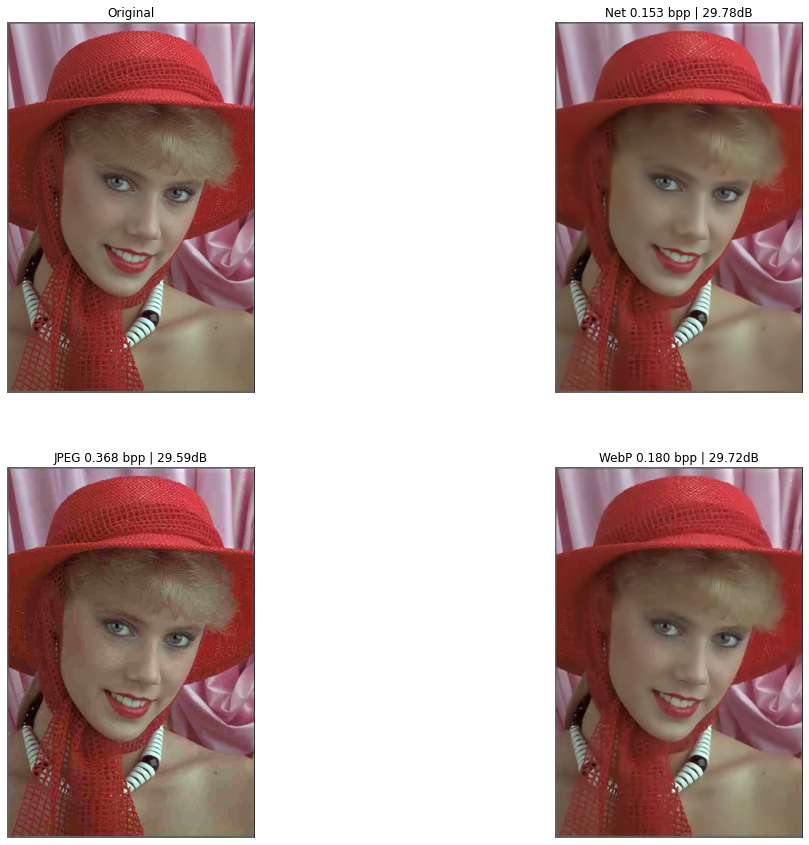

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for ax in axes.ravel():
    ax.axis('off')
    
axes[0][0].imshow(img)
axes[0][0].title.set_text('Original')
axes[0][1].imshow(rec_net)
axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp | {target_psnr:.2f}dB')
axes[1][0].imshow(rec_jpeg)
axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp | {psnr_jpeg:.2f}dB')
axes[1][1].imshow(rec_webp)
axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp | {psnr_webp:.2f}dB')

plt.show()

In [99]:
target_msssim = compute_msssim(x, out_net["x_hat"])
rec_jpeg, bpp_jpeg, msssim_jpeg = find_closest_msssim(target_msssim, img)
rec_webp, bpp_webp, msssim_webp = find_closest_msssim(target_msssim, img, fmt='webp')

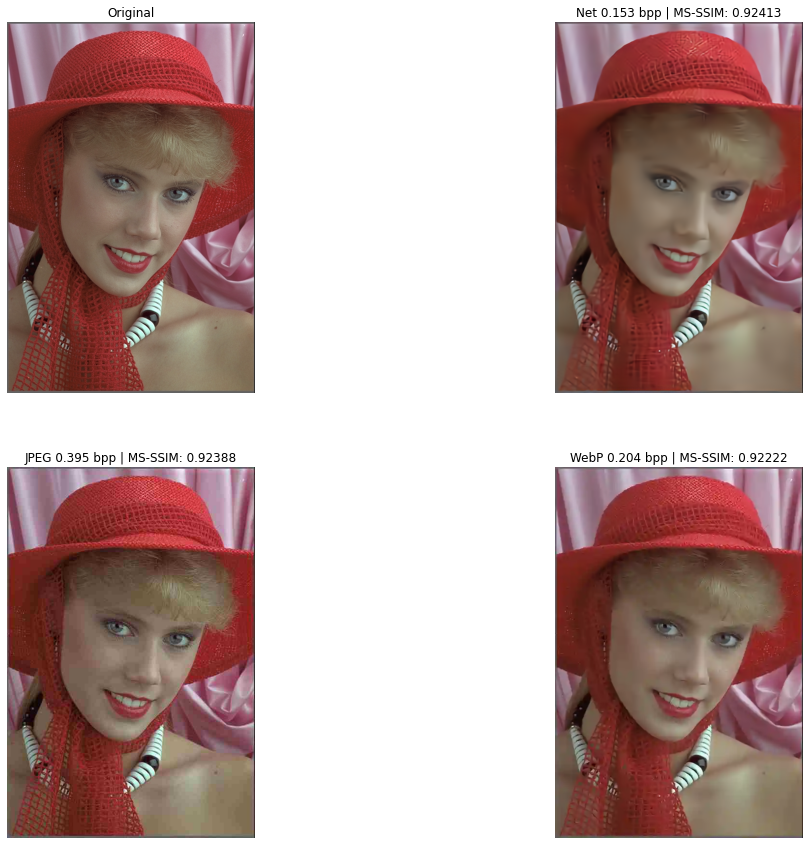

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for ax in axes.ravel():
    ax.axis('off')
    
axes[0][0].imshow(img)
axes[0][0].title.set_text('Original')
axes[0][1].imshow(rec_net)
axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp | MS-SSIM: {target_msssim:.5f}')
axes[1][0].imshow(rec_jpeg)
axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp | MS-SSIM: {msssim_jpeg:.5f}')
axes[1][1].imshow(rec_webp)
axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp | MS-SSIM: {msssim_webp:.5f}')

plt.show()

In [101]:
def detailed_bpp(out):
    size = out['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    for name, values in out_net['likelihoods'].items():
        bpp_val = torch.log(values).sum() / (-math.log(2) * num_pixels)
        print(f'- "{name}" latent bit-rate: {bpp_val:.3f} bpp')
               
detailed_bpp(out_net)

- "y" latent bit-rate: 0.153 bpp


In [102]:
with torch.no_grad():
    y = net.g_a(x)
    y_hat, y_likelihoods = net.entropy_bottleneck(y)
    print(y.size(), y_likelihoods.size())

torch.Size([1, 192, 48, 32]) torch.Size([1, 192, 48, 32])


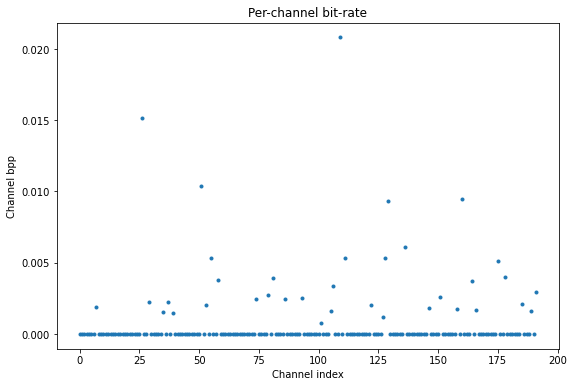

In [103]:
%matplotlib inline
num_pixels = x.size(2) * x.size(3)

channel_bpps = [torch.log(y_likelihoods[0, c]).sum().item() / (-math.log(2) * num_pixels)
                for c in range(y.size(1))]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

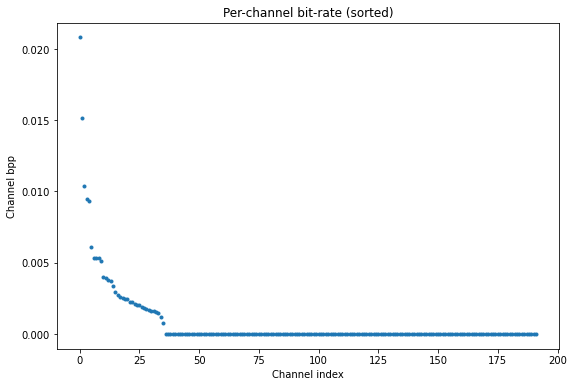

In [104]:
%matplotlib inline
num_pixels = x.size(2) * x.size(3)

ordered_idxs = torch.argsort(torch.Tensor(channel_bpps), descending=True)
ordered_channel_bpps = torch.Tensor(channel_bpps)[ordered_idxs]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(ordered_channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate (sorted)')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

In [105]:
from IPython.display import display, clear_output

In [111]:
%%capture
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 9))
for ax in axes:
    ax.axis('off')

out = widgets.Output()
def show_channel(c):
    channel = y[0, ordered_idxs[c]].cpu()
    axes[0].imshow(channel)
    axes[0].title.set_text(f'Y | min: {channel.min():.2f} | max: {channel.max():.2f}')
    
    channel = y_hat[0, ordered_idxs[c]].cpu()
    axes[1].imshow(channel)
    axes[1].title.set_text(f'Yhat | min: {channel.min():.2f} | max: {channel.max():.2f}')
    with out:
        clear_output(wait=True)
        display(fig)

In [112]:
slider = widgets.IntSlider(min=0, max=y.size(1)-1, step=1,continuous_update=False, description='Channel idx')
slider.observe(lambda ev: show_channel(slider.value))
show_channel(0)
display(widgets.VBox([out, slider]))

In [108]:
with torch.no_grad():
    x_hat_y = net.g_s(y).clamp_(0, 1)
    x_hat_y_hat = net.g_s(y_hat).clamp_(0, 1)

In [109]:
print('Decoded continuous latent:')
print(f'PSNR: {compute_psnr(x, x_hat_y):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, x_hat_y):.4f}')
print()
print('Decoded quantized latent:')
print(f'PSNR: {compute_psnr(x, x_hat_y_hat):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, x_hat_y_hat):.4f}')

Decoded continuous latent:
PSNR: 30.53dB
MS-SSIM: 0.9328

Decoded quantized latent:
PSNR: 29.78dB
MS-SSIM: 0.9241


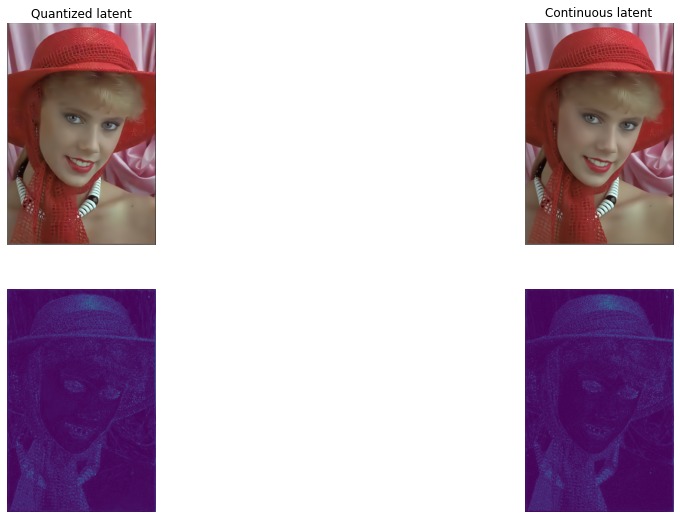

In [110]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(17, 9))
for ax in axes.ravel():
    ax.axis('off')
    
    axes[0][0].imshow(transforms.ToPILImage()(x_hat_y_hat.squeeze().cpu()))
    axes[0][0].title.set_text('Quantized latent')
    
    axes[1][0].imshow(torch.mean((x - x_hat_y_hat).abs(), axis=1).squeeze().cpu())
    
    axes[0][1].imshow(transforms.ToPILImage()(x_hat_y.squeeze()))
    axes[0][1].title.set_text('Continuous latent')
    
    axes[1][1].imshow(torch.mean((x - x_hat_y).abs(), axis=1).squeeze().cpu())

plt.show()